# Frechet Inception Distance (FID) — Notebook cell (copy-ready)

> Paste the code block that follows into **one** Jupyter cell and run it.
>
> All math in the markdown below uses single-dollar delimiters as requested.


In [2]:
# ---------- FID: definition, derivation, computation, and many visuals ----------
# Paste & run this single cell in a Jupyter notebook.
#
# This cell prints the derivation & definition (using $...$ in printed markdown),
# computes FID for toy 2D and 3D Gaussians step-by-step (printing intermediate values),
# and produces multiple plots (2D scatter+ellipses, 3D scatter+ellipsoids, and a FID heatmap).
#
# Requirements: numpy, matplotlib
# (Colab/Jupyter already have these; otherwise: pip install numpy matplotlib)
from IPython.display import display, Markdown
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math

# ---------------------------
# Markdown definition + derivation (uses $...$)
# ---------------------------

# Frechet Inception Distance (FID)

**Definition:** FID models two sets of image features as Gaussians and computes the Frechet distance between them.

Given two Gaussians $ \mathcal{N}(\mu_1, \Sigma_1) $ and $ \mathcal{N}(\mu_2, \Sigma_2) $, the FID is:

$ \mathrm{FID}(\mathcal{N}_1, \mathcal{N}_2) = \lVert \mu_1 - \mu_2 \rVert_2^2 \;+\; \mathrm{Tr}\left(\Sigma_1 + \Sigma_2 - 2(\Sigma_1 \Sigma_2)^{1/2}\right). $

**Derivation sketch:**
1. The squared 2-Wasserstein distance between two Gaussians has a closed form; for Gaussians it reduces to the expression above.
2. The first term measures difference in means: $ \lVert \mu_1 - \mu_2 \rVert_2^2 $.
3. The second term compares shape via covariances and requires the matrix square-root of $ \Sigma_1 \Sigma_2 $.
4. Numerically, compute matrix square-root via eigen-decomposition and clip tiny negative eigenvalues for stability.


=== 2D Example ===
Samples per set: 1000
True mu1: [0. 0.], True mu2: [1.5 0.7]
True sigma1:
 [[1.  0.5]
 [0.5 0.8]]
True sigma2:
 [[ 0.6 -0.2]
 [-0.2  0.5]]

Empirical mu1: [0.02388123 0.01157968]
Empirical sigma1:
 [[0.94293681 0.4743751 ]
 [0.4743751  0.77335617]]
Empirical mu2: [1.5447845  0.66267911]
Empirical sigma2:
 [[ 0.58783217 -0.20097172]
 [-0.20097172  0.48593216]]

FID (2D) components:
 - squared mean difference: 2.737077
 - trace term: 0.391835
 - FID: 3.128912
 - raw eigenvalues of product: [0.24836163 0.49105364]
 - clipped eigenvalues: [0.24836163 0.49105364]



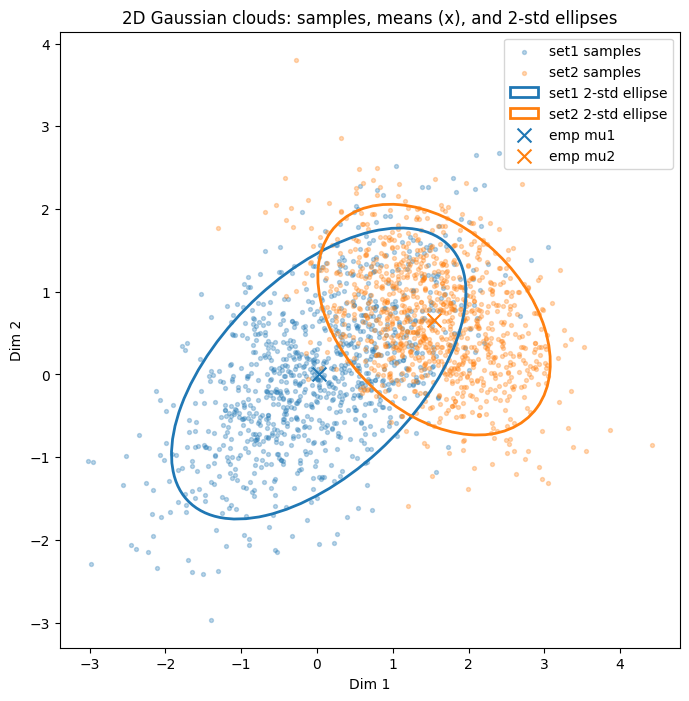

=== 3D Example ===
Empirical mu1_3d: [ 0.03010318 -0.0368606   0.00179228]
Empirical sigma1_3d:
 [[0.95890545 0.23824218 0.20063607]
 [0.23824218 0.80247254 0.09175352]
 [0.20063607 0.09175352 0.58710524]]
Empirical mu2_3d: [ 0.82693329 -0.46165574  0.27251776]
Empirical sigma2_3d:
 [[ 0.63874249 -0.15459025  0.02483432]
 [-0.15459025  0.58875431 -0.00886002]
 [ 0.02483432 -0.00886002  0.87782906]]

FID (3D) components:
 - squared mean difference: 0.888681
 - trace term: 0.206678
 - FID: 1.095359



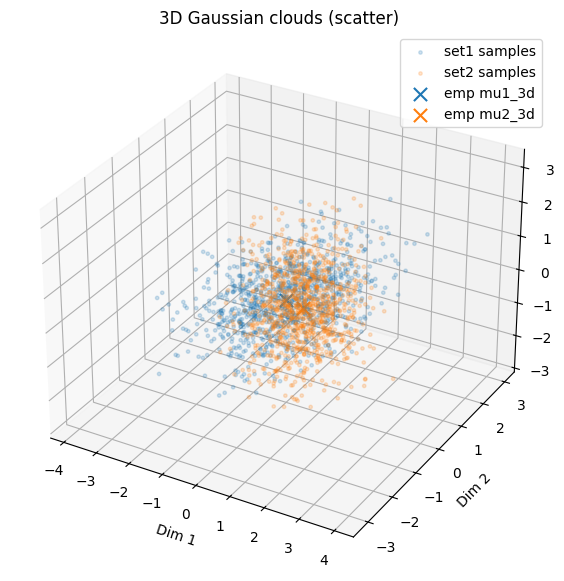

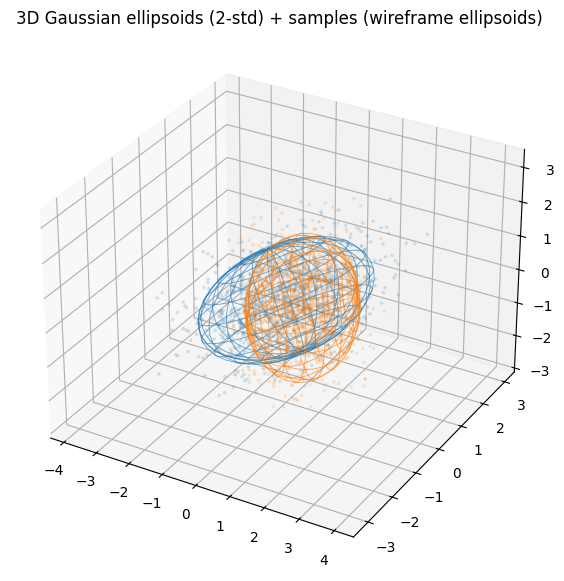

Computing FID heatmap when shifting mean2 across a grid (this may take a few seconds)...


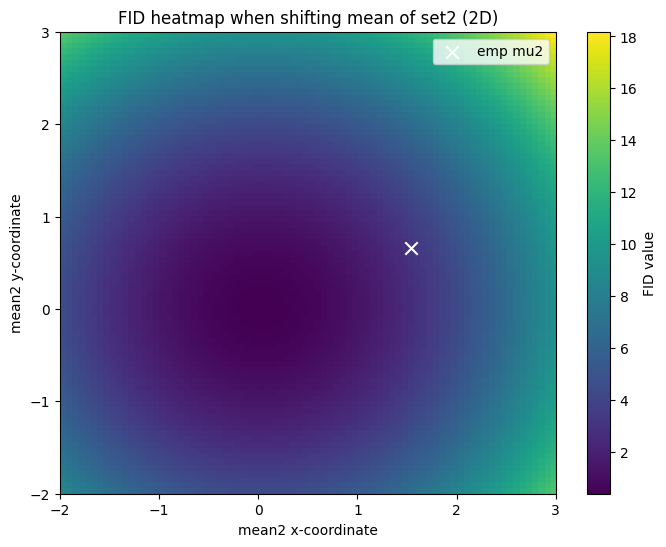

In [3]:
# ---------------------------
# Helper functions
# ---------------------------
def matrix_sqrt_via_eig(A, eps=1e-12):
    """
    Compute symmetric matrix square-root via eigen-decomposition.
    Returns sqrtA, raw_eigenvalues, clipped_eigenvalues.
    """
    # Ensure symmetric
    A_sym = (A + A.T) * 0.5
    vals, vecs = np.linalg.eigh(A_sym)
    # Clip very small negative eigenvalues to zero
    vals_clipped = np.clip(vals, a_min=0.0, a_max=None)
    sqrt_vals = np.sqrt(vals_clipped)
    sqrtA = (vecs * sqrt_vals) @ vecs.T
    return sqrtA, vals, vals_clipped

def frechet_distance(mu1, sigma1, mu2, sigma2, eps=1e-6):
    """
    Compute FID between two Gaussians parameterized by (mu1, sigma1) and (mu2, sigma2).
    Returns a dict with fid and intermediate components.
    """
    mu1 = np.asarray(mu1)
    mu2 = np.asarray(mu2)
    sigma1 = np.asarray(sigma1)
    sigma2 = np.asarray(sigma2)
    diff = mu1 - mu2
    mean_sq = diff.dot(diff)
    # Compute sqrt of sigma1 * sigma2 robustly
    cov_prod = sigma1 @ sigma2
    sqrt_prod, raw_eigs, clipped_eigs = matrix_sqrt_via_eig(cov_prod)
    # Numerical fallback: add small eps on diagonal if sqrt_prod contains nan or unstable
    if np.isnan(sqrt_prod).any():
        sigma1_eps = sigma1 + np.eye(sigma1.shape[0]) * eps
        sigma2_eps = sigma2 + np.eye(sigma2.shape[0]) * eps
        cov_prod = sigma1_eps @ sigma2_eps
        sqrt_prod, raw_eigs, clipped_eigs = matrix_sqrt_via_eig(cov_prod)
    trace_term = np.trace(sigma1 + sigma2 - 2.0 * sqrt_prod)
    fid = mean_sq + trace_term
    return {
        'fid': float(fid),
        'mean_sq_distance': float(mean_sq),
        'trace_term': float(trace_term),
        'sqrt_prod': sqrt_prod,
        'raw_eigenvalues': raw_eigs,
        'clipped_eigenvalues': clipped_eigs
    }

# ---------------------------
# Utilities for plotting ellipses/ellipsoids
# ---------------------------
def plot_cov_ellipse(ax, mu, cov, nstd=2.0, edgecolor='k', label=None):
    """
    Plot 2D covariance ellipse on provided Axes `ax`.
    """
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    # angle of largest eigenvector
    theta = np.degrees(np.arctan2(vecs[1,0], vecs[0,0]))
    width, height = 2 * nstd * np.sqrt(vals)
    from matplotlib.patches import Ellipse
    ell = Ellipse(xy=mu, width=width, height=height, angle=theta, fill=False, linewidth=2, edgecolor=edgecolor)
    if label:
        ell.set_label(label)
    ax.add_patch(ell)

def plot_cov_ellipsoid(ax, mu, cov, nstd=2.0, color='C0', alpha=0.5):
    """
    Plot 3D ellipsoid wireframe representing covariance `cov` centered at `mu`.
    """
    # Use SVD for rotation & scaling
    u, s, vh = np.linalg.svd(cov)
    # radii along principal axes
    radii = nstd * np.sqrt(s)
    # parametric sphere
    u_angles = np.linspace(0.0, 2.0*np.pi, 40)
    v_angles = np.linspace(0.0, np.pi, 20)
    x = np.outer(np.cos(u_angles), np.sin(v_angles))
    y = np.outer(np.sin(u_angles), np.sin(v_angles))
    z = np.outer(np.ones_like(u_angles), np.cos(v_angles))
    # transform sphere points
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            vec = np.array([x[i,j], y[i,j], z[i,j]])
            vec = vec * radii  # scale
            pt = u @ vec + mu
            x[i,j], y[i,j], z[i,j] = pt[0], pt[1], pt[2]
    ax.plot_wireframe(x, y, z, rstride=2, cstride=2, color=color, alpha=alpha, linewidth=0.7)

# ---------------------------
# Part A: 2D demonstration (samples, empirical stats, FID step-by-step, visuals)
# ---------------------------
np.random.seed(0)
n_samples = 1000

# Define two toy 2D Gaussians
mu1_2d = np.array([0.0, 0.0])
sigma1_2d = np.array([[1.0, 0.5], [0.5, 0.8]])
mu2_2d = np.array([1.5, 0.7])
sigma2_2d = np.array([[0.6, -0.2], [-0.2, 0.5]])

# Sample from them (visualization)
x1 = np.random.multivariate_normal(mu1_2d, sigma1_2d, size=n_samples)
x2 = np.random.multivariate_normal(mu2_2d, sigma2_2d, size=n_samples)

print("=== 2D Example ===")
print(f"Samples per set: {n_samples}")
print(f"True mu1: {mu1_2d}, True mu2: {mu2_2d}")
print("True sigma1:\n", sigma1_2d)
print("True sigma2:\n", sigma2_2d)
print()

# Empirical estimates (like when we compute FID from features)
emp_mu1 = x1.mean(axis=0)
emp_sigma1 = np.cov(x1, rowvar=False)
emp_mu2 = x2.mean(axis=0)
emp_sigma2 = np.cov(x2, rowvar=False)

print("Empirical mu1:", emp_mu1)
print("Empirical sigma1:\n", emp_sigma1)
print("Empirical mu2:", emp_mu2)
print("Empirical sigma2:\n", emp_sigma2)
print()

# Compute FID (prints components)
fid_2d = frechet_distance(emp_mu1, emp_sigma1, emp_mu2, emp_sigma2)
print("FID (2D) components:")
print(f" - squared mean difference: {fid_2d['mean_sq_distance']:.6f}")
print(f" - trace term: {fid_2d['trace_term']:.6f}")
print(f" - FID: {fid_2d['fid']:.6f}")
print(" - raw eigenvalues of product:", fid_2d['raw_eigenvalues'])
print(" - clipped eigenvalues:", fid_2d['clipped_eigenvalues'])
print()

# Plot 2D scatter + covariance ellipses
fig, ax = plt.subplots(figsize=(8,8))
ax.scatter(x1[:,0], x1[:,1], s=8, alpha=0.3, label='set1 samples')
ax.scatter(x2[:,0], x2[:,1], s=8, alpha=0.3, label='set2 samples')
plot_cov_ellipse(ax, emp_mu1, emp_sigma1, nstd=2, edgecolor='C0', label='set1 2-std ellipse')
plot_cov_ellipse(ax, emp_mu2, emp_sigma2, nstd=2, edgecolor='C1', label='set2 2-std ellipse')
ax.scatter(emp_mu1[0], emp_mu1[1], marker='x', s=100, color='C0', label='emp mu1')
ax.scatter(emp_mu2[0], emp_mu2[1], marker='x', s=100, color='C1', label='emp mu2')
ax.set_title("2D Gaussian clouds: samples, means (x), and 2-std ellipses")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.legend()
plt.show()

# ---------------------------
# Part B: 3D demonstration
# ---------------------------
mu1_3d = np.array([0.0, 0.0, 0.0])
sigma1_3d = np.array([[1.0, 0.3, 0.2],
                      [0.3, 0.8, 0.1],
                      [0.2, 0.1, 0.6]])
mu2_3d = np.array([0.8, -0.5, 0.3])
sigma2_3d = np.array([[0.7, -0.2, 0.05],
                      [-0.2, 0.6, 0.0],
                      [0.05, 0.0, 0.9]])

x1_3d = np.random.multivariate_normal(mu1_3d, sigma1_3d, size=n_samples)
x2_3d = np.random.multivariate_normal(mu2_3d, sigma2_3d, size=n_samples)

emp_mu1_3d = x1_3d.mean(axis=0)
emp_sigma1_3d = np.cov(x1_3d, rowvar=False)
emp_mu2_3d = x2_3d.mean(axis=0)
emp_sigma2_3d = np.cov(x2_3d, rowvar=False)

print("=== 3D Example ===")
print("Empirical mu1_3d:", emp_mu1_3d)
print("Empirical sigma1_3d:\n", emp_sigma1_3d)
print("Empirical mu2_3d:", emp_mu2_3d)
print("Empirical sigma2_3d:\n", emp_sigma2_3d)
print()

fid_3d = frechet_distance(emp_mu1_3d, emp_sigma1_3d, emp_mu2_3d, emp_sigma2_3d)
print("FID (3D) components:")
print(f" - squared mean difference: {fid_3d['mean_sq_distance']:.6f}")
print(f" - trace term: {fid_3d['trace_term']:.6f}")
print(f" - FID: {fid_3d['fid']:.6f}")
print()

# 3D scatter
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(x1_3d[:,0], x1_3d[:,1], x1_3d[:,2], s=6, alpha=0.2, label='set1 samples')
ax.scatter(x2_3d[:,0], x2_3d[:,1], x2_3d[:,2], s=6, alpha=0.2, label='set2 samples')
ax.scatter(emp_mu1_3d[0], emp_mu1_3d[1], emp_mu1_3d[2], marker='x', s=90, color='C0', label='emp mu1_3d')
ax.scatter(emp_mu2_3d[0], emp_mu2_3d[1], emp_mu2_3d[2], marker='x', s=90, color='C1', label='emp mu2_3d')
ax.set_title("3D Gaussian clouds (scatter)")
ax.set_xlabel("Dim 1")
ax.set_ylabel("Dim 2")
ax.set_zlabel("Dim 3")
ax.legend()
plt.show()

# 3D ellipsoids (wireframe)
fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(projection='3d')
ax.scatter(x1_3d[:,0], x1_3d[:,1], x1_3d[:,2], s=3, alpha=0.12)
ax.scatter(x2_3d[:,0], x2_3d[:,1], x2_3d[:,2], s=3, alpha=0.12)
plot_cov_ellipsoid(ax, emp_mu1_3d, emp_sigma1_3d, nstd=2.0, color='C0', alpha=0.6)
plot_cov_ellipsoid(ax, emp_mu2_3d, emp_sigma2_3d, nstd=2.0, color='C1', alpha=0.6)
ax.set_title("3D Gaussian ellipsoids (2-std) + samples (wireframe ellipsoids)")
plt.show()

# ---------------------------
# Part C: FID heatmap when varying mean2 in 2D
# ---------------------------
print("Computing FID heatmap when shifting mean2 across a grid (this may take a few seconds)...")
grid_x = np.linspace(-2.0, 3.0, 80)
grid_y = np.linspace(-2.0, 3.0, 80)
grid_fid = np.zeros((len(grid_x), len(grid_y)))
for i, gx in enumerate(grid_x):
    for j, gy in enumerate(grid_y):
        mu2_tmp = np.array([gx, gy])
        stats_tmp = frechet_distance(emp_mu1, emp_sigma1, mu2_tmp, emp_sigma2)
        grid_fid[i,j] = stats_tmp['fid']

fig, ax = plt.subplots(figsize=(8,6))
im = ax.imshow(grid_fid.T, origin='lower', extent=(grid_x[0], grid_x[-1], grid_y[0], grid_y[-1]), aspect='auto')
ax.set_title("FID heatmap when shifting mean of set2 (2D)")
ax.set_xlabel("mean2 x-coordinate")
ax.set_ylabel("mean2 y-coordinate")
cbar = plt.colorbar(im, ax=ax)
cbar.set_label('FID value')
# mark empirical mu2
ax.scatter(emp_mu2[0], emp_mu2[1], marker='x', s=80, color='white', label='emp mu2')
ax.legend()
plt.show()